In [8]:
import pandas as pd
import matplotlib.pyplot as plt

This Notebook uses the event observations made for customers in `create-churn-dataset` to perform cohort analysis for a monthly metrics of interest.

The procedure is as follows:

1. Using the metric and the variable representing churn or non-churn, sort the observations by metric value.
2. Group the observations into cohorts by dividing the observations into equal-sized groups (we default to deciles).
3. For each cohort, calculate:
    - the average value of the metric for all observations in the cohort
    - the percentage of churns in the cohort observations
4. Plot the average metric values and churn rates.

Sometimes, a customer appears more than once in one cohort;
at other times, the same customer appears in different cohorts. This makes sense because we're investigating the hypothesis that the behaviour represented by the metric is related to churn, not that the identity of the customer or the timing of the observation is related to churn. 

To show how using scored (normalised) metrics makes it easy to see how cohorts related to the average metric value (particularly when the metric is skewed), we also plot figures of the scored version of each cohort analysis. The code for calculating cohorts from scored versions of the metrics is exactly the same.

In [42]:
data_set_path = '../../output/socialnet_dataset.csv'
scored_data_set_path = '../../output/socialnet_dataset_scores.csv'
churn_data = pd.read_csv(data_set_path, index_col=[0, 1])
churn_data_scored = pd.read_csv(scored_data_set_path, index_col=[0, 1])

In [10]:
per_month_metrics = churn_data.filter(regex='_per_month$').columns.to_list()

In [56]:
# produce a cohort analysis dataframe for the chosen metric
def create_cohort_frame(df, metric_to_plot, ncohort=10):
    # group into cohorts and return a series of the group numbers
    groups = pd.qcut(df[metric_to_plot], ncohort, duplicates='drop')
    # calculate the mean metric value for each cohort
    cohort_means = df.groupby(groups)[metric_to_plot].mean()
    # calculate the churn rate for each cohort
    cohort_churns = df.groupby(groups)['is_churn'].mean()
    # msk a new DataFrame from the cohorts
    plot_frame = pd.DataFrame({
        metric_to_plot: cohort_means.values,
        'churn_rate': cohort_churns
        })
    return plot_frame
    
def cohort_plot(plot_frame, metric_to_plot, ax, scored=False):
    ax.plot(metric_to_plot, 
             'churn_rate',
             data=plot_frame,
             marker='o',
             linewidth=2,
             label=metric_to_plot)
    ax.grid()
    if not scored:
        ax.set_xlim(left=0)

### Cohorts of behaviour metrics

With 10 cohorts, each cohort will have about 930 observations, so we can be confident that the noise of random events won't overwhelm the signal we're looking for.

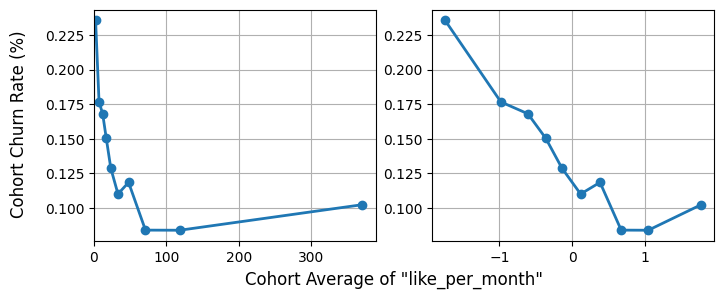

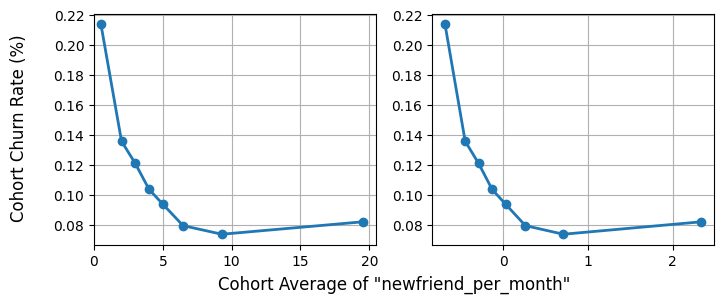

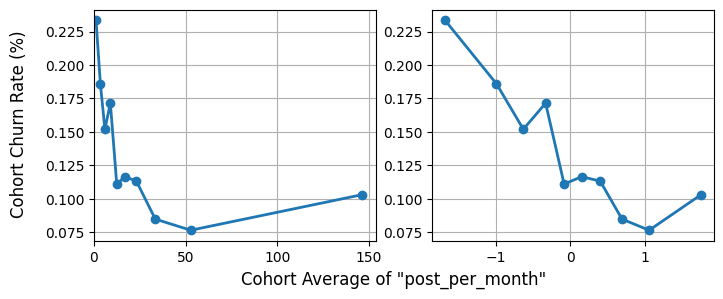

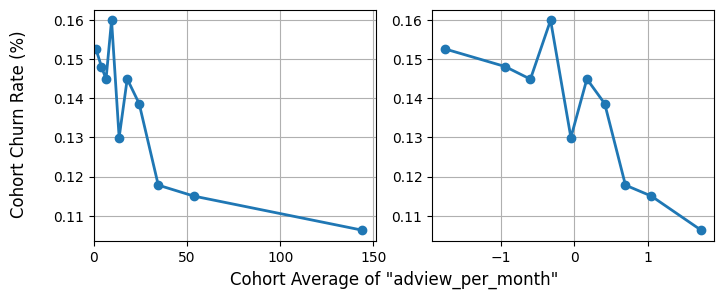

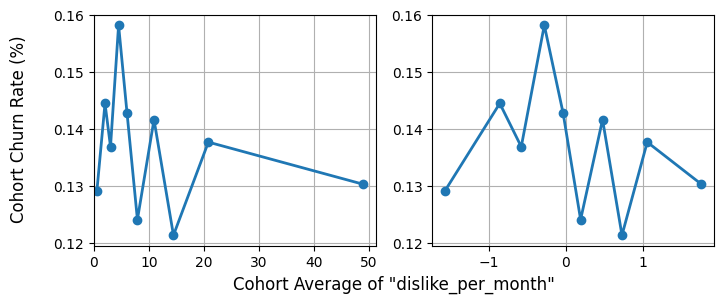

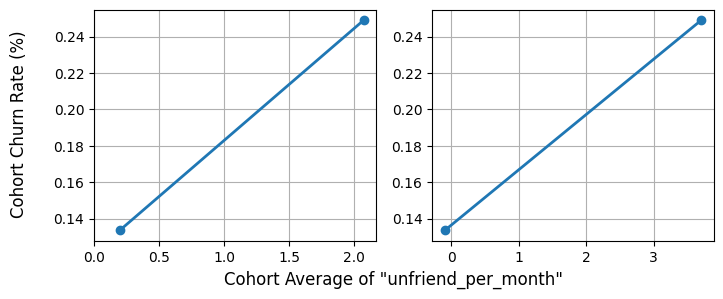

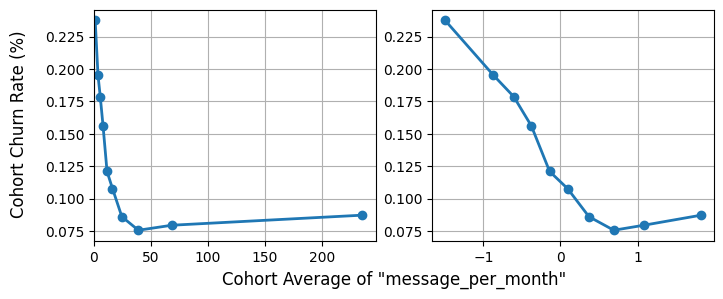

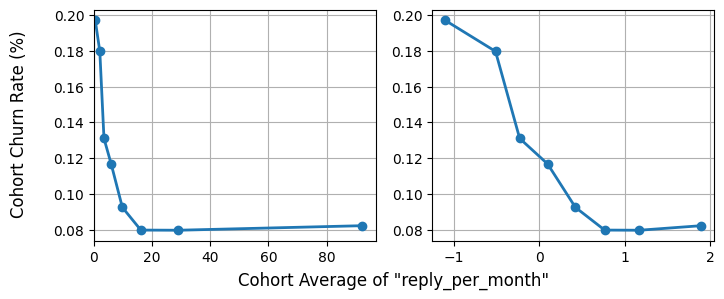

In [58]:
# produce plots of cohort analysis for each of our "per_month" metrics:
for metric_name in per_month_metrics:
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    plot_frame = create_cohort_frame(churn_data, metric_name)
    plot_frame_scored = create_cohort_frame(churn_data_scored, metric_name)
    cohort_plot(plot_frame, metric_name, axs[0])
    cohort_plot(plot_frame_scored, metric_name, axs[1], scored=True)
    fig.supxlabel('Cohort Average of "%s"' % metric_name, va='top')
    fig.supylabel('Cohort Churn Rate (%)')
    plt.show()

Cohort churn analyses for real products and services typically have this shape, with the cohort churn rates falling rapidly in the first couple of cohorts, for higher cohorts the churn rate is more or less constant. 

This is useful because it's easy to identify a healthy level for the metric: the level where churn rates stop declining. 

It’s a problem because after a certain point, that metric no longer helps us understand churn or segment customers based on churn risk. In terms of intervening to reduce churn, getting users to take more of certain actions doesn’t make a difference past a certain point. 